# Goals

* Create a pipeline to gather new datasets from GEO and SRA

# Init

In [1]:
import os
import time
import json
import operator
from functools import partial
from enum import Enum
from pprint import pprint
from typing import Annotated, List, Dict, Tuple, Optional, Union, Any, TypedDict
import xml.etree.ElementTree as ET
from pydantic import BaseModel, Field
from langchain_core.tools import tool
from Bio import Entrez
import pandas as pd
from dotenv import load_dotenv

In [2]:
from SRAgent.agents.entrez import create_entrez_agent
from SRAgent.agents.utils import create_step_summary_chain
from SRAgent.tools.convert import geo2sra

In [3]:
# setup
load_dotenv()
pd.set_option('display.max_colwidth', 1000)
os.environ["DEBUG_MODE"] = "TRUE"

In [4]:
# checks
if os.getenv("DEBUG_MODE") == "TRUE":
    print("DEBUG_MODE is enabled.")

DEBUG_MODE is enabled.


In [5]:
# set up Entrez
Entrez.email = "nick.youngblut@arcinstitute.org"
Entrez.api_key = os.getenv("NCBI_API_KEY")

# Entrez agent

In [6]:
# create entrez agent
entrez_agent = create_entrez_agent()
step_summary_chain = create_step_summary_chain()    

In [7]:
# invoke agent
input = {"messages": [("user", "Convert GSE121737 to SRX accessions")]}
#invoke_entrez_agent(input, entrez_agent, step_summary_chain)

In [8]:
entrez_id = "35966237"
content = f"Obtain SRX accessions associated with Entrez ID {entrez_id}"
input = {"messages": [("user", content)]}
# invoke_entrez_agent(input, entrez_agent, step_summary_chain)

In [9]:
SRX_id = "SRX4967527"
content = f"Obtain SRR accessions associated with {SRX_id}"
input = {"messages": [("user", content)]}
# invoke_entrez_agent(input, entrez_agent, step_summary_chain)

# Graph

In [10]:
from langgraph.types import Send
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage

In [11]:
from SRAgent.tools.esearch import esearch_scrna

In [12]:
class YesNo(Enum):
    Yes = "Yes"
    No = "No"
    Not_sure = "Not sure"

In [13]:
class TopState(TypedDict):
    """
    Shared state of the agents in the graph
    """
    database: str
    # esearch IDs
    entrez_ids: Annotated[List[str], operator.add]
    # converted IDs
    converted_entrez_ids: Annotated[List[str], operator.add]
    # accessions
    SRX: Annotated[List[str], operator.add]
    # is_single_cell
    is_single_cell: Annotated[List[YesNo], operator.add]
    # is_illumina
    is_illumina: Annotated[List[YesNo], operator.add]
    # is_paired_end
    is_paired_end: Annotated[List[YesNo], operator.add]
    # is_10x
    is_10x: Annotated[List[YesNo], operator.add]
    # explanations
    explanations: Annotated[List[str], operator.add]

## Nodes

In [14]:
def invoke_esearch(state: TopState):
    query = '("single cell RNA sequencing" OR "single cell RNA-seq")'
    entrez_ids = esearch_scrna.invoke({"esearch_query" : query, "database" : state["database"]})
    return {"entrez_ids" : entrez_ids}

# invoke_esearch({"database" : "gds", "entrez_ids" : []})

In [15]:
# create react agent
def invoke_sra2geo(state: TopState):
    """
    Invoke the geo2sra tool to get SRA accessions for a GEO dataset.
    """
    # invoke tool
    sra_ids = geo2sra.invoke({"entrez_ids" : state["entrez_ids"]})
    # update state
    return {"converted_entrez_ids" : sra_ids, "database" : "sra"}

# invoke_sra2geo({"entrez_ids" : ["200274955"]})

In [16]:
# ID conversion router
def id_convert_router(state: TopState):
    """
    Route the Entrez IDs to the appropriate conversion tool.
    """
    if state["database"] == "gds":
        return ["id_convert_node"]
    else:
        return ["id_agg_node"]

In [17]:
# aggregation node
def id_agg(state: TopState):
    """
    Aggregate IDs from various nodes
    """
    return {"database" : state["database"]}

In [ ]:
# conversion subgraph
from SRAgent.agents.convert import create_convert_graph, invoke_convert_graph
invoke_convert_graph_p = partial(
    invoke_convert_graph,
    graph = create_convert_graph(),
    to_return = ["SRX"]
)

In [43]:
# Parallel invoke of the subgraph
def continue_to_conversion(state: TopState):
    entrez_ids = state["entrez_ids"]
    # invoke the subgraph for each ID
    response = []
    for entrez_id in entrez_ids:
        input = {"messages": HumanMessage(
            f"Convert Entrez ID {entrez_id} to SRX accessions."
            " The Entrez ID is associated with the SRA database."
        )}
        response.append(Send("convert_graph_node", input))
    return response

In [38]:
def final_state(state: TopState):
    # return final state
    return {
        "database": state["database"],
        "entrez_ids": state["entrez_ids"],
        "SRX": state["SRX"]
    }

## Compile

In [39]:
from langgraph.graph import START, END, StateGraph

In [40]:
#-- graph --#
workflow = StateGraph(TopState)

# nodes
workflow.add_node("esearch_node", invoke_esearch)
workflow.add_node("id_convert_node", invoke_sra2geo)
workflow.add_node("id_agg_node", id_agg)
workflow.add_node("convert_graph_node", invoke_convert_graph_p)
workflow.add_node("final_state_node", final_state)

# edges
workflow.add_edge(START, "esearch_node")
workflow.add_conditional_edges("esearch_node", id_convert_router, ["id_convert_node", "id_agg_node"])
workflow.add_edge("id_convert_node", "id_agg_node")
workflow.add_conditional_edges("id_agg_node", continue_to_conversion, ["convert_graph_node"])
workflow.add_edge("convert_graph_node", "final_state_node")
workflow.add_edge("final_state_node", END)

# compile the graph
graph = workflow.compile()

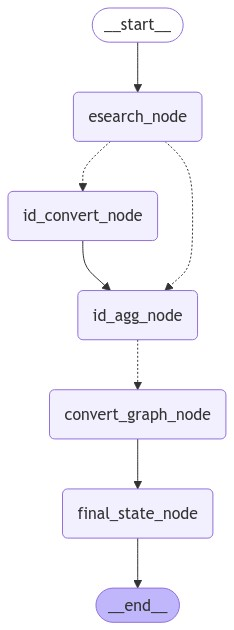

In [41]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())

In [ ]:
# Call the graph: SRA database
final_state = None
for step in graph.stream({"database": "sra"}, subgraphs=True, config={"max_concurrency" : 3, "recursion_limit": 50}):
    print(step)
    final_state = step
print("---")
print(final_state)

((), {'esearch_node': {'entrez_ids': ['36098095', '36098080']}})
((), {'id_agg_node': {'database': 'sra'}})
(('convert_graph_node:9a5e2e4e-4170-dd8f-3e25-f764f2e412f0', 'entrez_agent_node:128b5fc6-b5ca-e491-38a1-54a295acdb69'), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_hpMrzA0O9JOFNQdq6Ggd6Q5V', 'function': {'arguments': '{"message":"Fetch the SRA accessions for Entrez ID 36098095"}', 'name': 'invoke_efetch_worker'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 951, 'total_tokens': 981, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a7d06e42a7', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c40ea956-bc1c-42f2-982f-b7feea9db88c-0', tool_c